Processing file: CM1.csv
Selected features: Index(['CALL_PAIRS', 'LOC_COMMENTS', 'LOC_EXECUTABLE', 'HALSTEAD_CONTENT',
       'HALSTEAD_LENGTH', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS',
       'NUM_UNIQUE_OPERATORS', 'NUMBER_OF_LINES', 'LOC_TOTAL'],
      dtype='object')
Mean Accuracy: 0.8596491228070174
Mean F1 Score: 0.8754209934259503
Mean AUC Score: 0.9147783251231527
Mean G-Mean Score: 0.8512709853061761
Processing file: KC1.csv
Selected features: Index(['LOC_BLANK', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_ERROR_EST',
       'HALSTEAD_LENGTH', 'HALSTEAD_VOLUME', 'NUM_OPERANDS', 'NUM_OPERATORS',
       'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS', 'LOC_TOTAL'],
      dtype='object')
Mean Accuracy: 0.7569031958009435
Mean F1 Score: 0.7666678018113744
Mean AUC Score: 0.8306882110935977
Mean G-Mean Score: 0.7552896252671152
Processing file: KC3.csv
Selected features: Index(['LOC_BLANK', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_EXECUTABLE',
       'HALSTEAD_CONTENT', 'NODE_COUNT', 'NUM_OPER

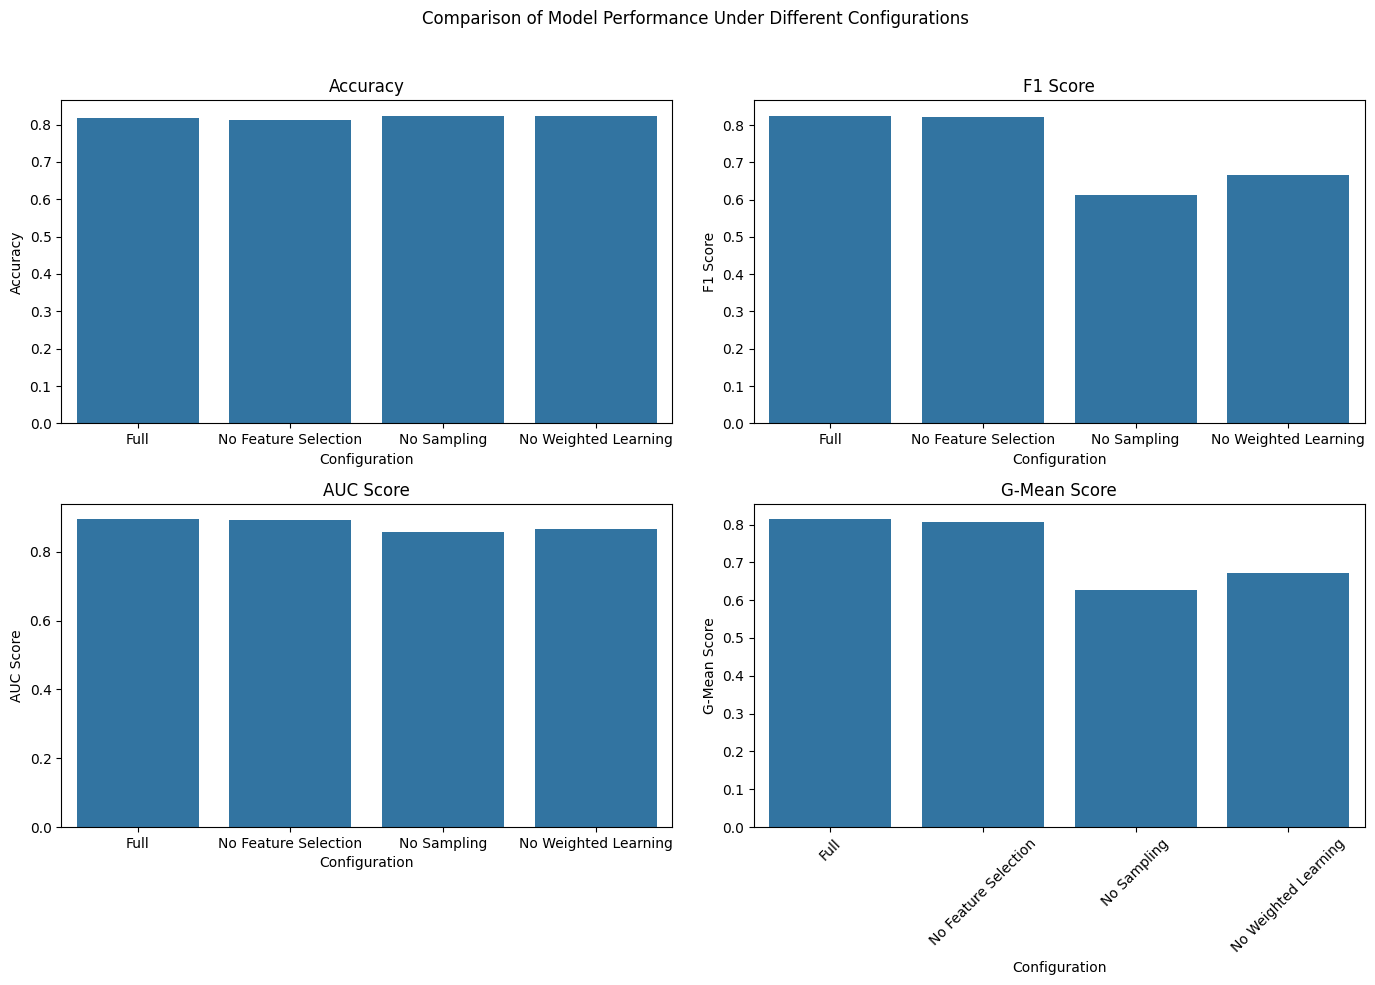

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt 

def load_data(data_folder):
    data_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.csv')]
    dataframes = [pd.read_csv(file) for file in data_files]
    file_names = [os.path.basename(file) for file in data_files]
    return dataframes, file_names

def preprocess_data(df):
    imputer = KNNImputer(n_neighbors=5)
    columns_to_impute = df.columns.difference(['Defective', 'id'])
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    
    df['Defective'] = df['Defective'].map({'Y': 1, 'N': 0})
    
    scaler = StandardScaler()
    columns_to_scale = df.columns.difference(['Defective', 'id'])
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    df[columns_to_scale] = (df[columns_to_scale] - df[columns_to_scale].min()) / (df[columns_to_scale].max() - df[columns_to_scale].min())
    
    return df

def select_k_best_features(df, k=10):
    X = df.drop(columns=['Defective', 'id'])
    y = df['Defective']
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X = selector.fit_transform(X, y)
    
    selected_features = df.drop(columns=['Defective', 'id']).columns[selector.get_support(indices=True)]
    print(f"Selected features: {selected_features}")
    
    return selected_features

def train_and_evaluate_model(X, y):
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    w_svm = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
    lr = LogisticRegression(class_weight='balanced', random_state=42)
    mnb = MultinomialNB()
    bnb = BernoulliNB()
    
    ensemble_model = VotingClassifier(estimators=[
        ('rf', rf), 
        ('w_svm', w_svm), 
        ('lr', lr), 
        ('mnb', mnb), 
        ('bnb', bnb)
    ], voting='soft')
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(ensemble_model, X, y, cv=cv, scoring='accuracy')
    
    gmean_scorer = make_scorer(geometric_mean_score)
    
    mean_accuracy = np.mean(cv_scores)
    f1_scores = cross_val_score(ensemble_model, X, y, cv=cv, scoring='f1')
    mean_f1 = np.mean(f1_scores)
    auc_scores = cross_val_score(ensemble_model, X, y, cv=cv, scoring='roc_auc')
    mean_auc = np.mean(auc_scores)
    gmean_scores = cross_val_score(ensemble_model, X, y, cv=cv, scoring=gmean_scorer)
    mean_gmean = np.mean(gmean_scores)
    
    print(f"Mean Accuracy: {mean_accuracy}")
    print(f"Mean F1 Score: {mean_f1}")
    print(f"Mean AUC Score: {mean_auc}")
    print(f"Mean G-Mean Score: {mean_gmean}")

    return mean_accuracy, mean_f1, mean_auc, mean_gmean
    
results = []

def main(data_folder, use_feature_selection=True, use_sampling=True, use_weighted_learning=True):
    dataframes, file_names = load_data(data_folder)
    i = 0
    
    for df in dataframes:
        preprocessed_dataframes = preprocess_data(df)
        X = preprocessed_dataframes.drop(columns=['Defective', 'id'])
        y = preprocessed_dataframes['Defective']
        print(f"Processing file: {os.path.basename(file_names[i])}")
        i += 1
        
        if use_feature_selection:
            selected_features = select_k_best_features(preprocessed_dataframes, k=10)
            X = preprocessed_dataframes[selected_features]
        
        if use_sampling:
            smote = SMOTE(random_state=42)
            X, y = smote.fit_resample(X, y)
        
        mean_accuracy, mean_f1, mean_auc, mean_gmean = train_and_evaluate_model(X, y)

        results.append({
            'Accuracy': mean_accuracy,
            'F1 Score': mean_f1,
            'AUC Score': mean_auc,
            'G-Mean Score': mean_gmean
        })

    results_df = pd.DataFrame(results)
    return results_df['Accuracy'].mean(), results_df['F1 Score'].mean(), results_df['AUC Score'].mean(), results_df['G-Mean Score'].mean()

    
    
    #excel_path = 'D:\\ISE\\Challenge Task 1- Software Defect Prediction\\work\\model_evaluation_results.xlsx'
    #with pd.ExcelWriter(excel_path, mode='a', engine='openpyxl') as writer:
    #    results_df.to_excel(writer, sheet_name='New Results', index=False)

data_folder = 'D:\\ISE\\ML\\Challenge Task 1- Software Defect Prediction\\data\\Software Defect Prediction - Data\\dataNASA'
full_acc, full_f1, full_auc, full_g = main(data_folder, use_feature_selection=True, use_sampling=True, use_weighted_learning=True)
no_fs_acc, no_fs_f1, no_fs_auc, no_fs_g = main(data_folder, use_feature_selection=False, use_sampling=True, use_weighted_learning=True)
no_sampling_acc, no_sampling_f1, no_sampling_auc, no_sampling_g = main(data_folder, use_feature_selection=True, use_sampling=False, use_weighted_learning=True)
no_weighted_acc, no_weighted_f1, no_weighted_auc, no_weighted_g = main(data_folder, use_feature_selection=True, use_sampling=True, use_weighted_learning=False)

# Create a DataFrame to store the results
comparison_df = pd.DataFrame({
    'Configuration': ['Full', 'No Feature Selection', 'No Sampling', 'No Weighted Learning'],
    'Accuracy': [full_acc, no_fs_acc, no_sampling_acc, no_weighted_acc],
    'F1 Score': [full_f1, no_fs_f1, no_sampling_f1, no_weighted_f1],
    'AUC Score': [full_auc, no_fs_auc, no_sampling_auc, no_weighted_auc],
    'G-Mean Score': [full_g, no_fs_g, no_sampling_g, no_weighted_g]
})

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison of Model Performance Under Different Configurations')

sns.barplot(ax=axes[0, 0], x='Configuration', y='Accuracy', data=comparison_df)
axes[0, 0].set_title('Accuracy')

sns.barplot(ax=axes[0, 1], x='Configuration', y='F1 Score', data=comparison_df)
axes[0, 1].set_title('F1 Score')

sns.barplot(ax=axes[1, 0], x='Configuration', y='AUC Score', data=comparison_df)
axes[1, 0].set_title('AUC Score')

sns.barplot(ax=axes[1, 1], x='Configuration', y='G-Mean Score', data=comparison_df)
axes[1, 1].set_title('G-Mean Score')

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

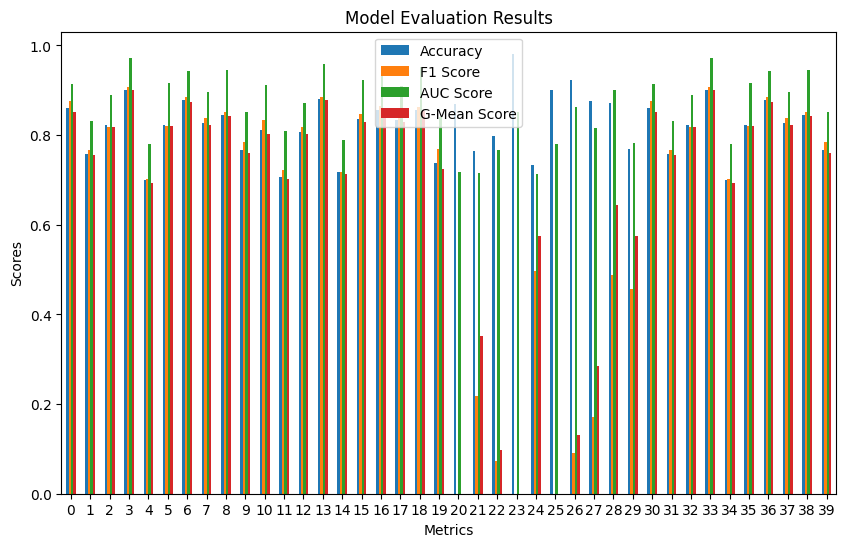

In [5]:
# Assuming results_df is already defined in the previous cells
results_df = pd.DataFrame(results)
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Evaluation Results')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.show()